# PCA On Fire Images

## Introduction

PCA is mostly known as a dimensionality reduction technique that aims in preserving most of the variance and providing a new **uncorellated** feature space.
  
However, in our case we will use PCA in an attempt to **reduce noise on fire images**.  

This a not so usual use case of PCA. Admittedly the inspiration came from  [Ali Ghodsi](https://uwaterloo.ca/statistics-and-actuarial-science/people-profiles/ali-ghodsi) on a statistical learning course he gave. I suggest his [playlist](https://www.youtube.com/playlist?list=PLehuLRPyt1HzXDemu7K4ETcF0Ld_B5adG) for anyone wanting a more intuitive and mathematical approach on the field of ML and data science in general.

* **Why fire images?**  
Normally the suggested flow would be to get the [MNIST digits dataset](http://yann.lecun.com/exdb/mnist/) apply some random noise, apply denoising using PCA and explore the visual results. However, this [already exists](https://stats.stackexchange.com/a/247271). Also, a friend of mine (who generously gave me access to his dataset) is writing his thesis on fire recognition on images, so we could test our results. 

Steps for applying PCA for denoising an image dataset in general:
1. Let $X$ be our datapoints of shape $nxm$ where $n$ features (number of pixels), $m$ datapoints
2. Centralize $X$ by $M_X$ (mean matrix of $X$) to get centralized $\bar{X}=X
- M_X$
3. Calculate $C_\bar{X} = \bar{X}\bar{X^T}$ (Covariance of $\bar{X}$ since $X$ is centralized) 
4. Let $U_p$ the first $p$ eigenvectors of  $C_\bar{X}$ ($p$ is decided by us to cover as much variance as we want)
5. Encode the training data $Y=U_p^T\bar{X}$ (dimensionality reduction)
6. Return to the starting dimensions $\hat{X}=U_pY$
7. Recenter our datapoints $X_{final}=\hat{X} + M_X$

**Note: On the code below I use the [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), which performs some of the above steps implicitly.**


In [1]:
import os
import random 

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm

## Reading the images

The first thing we are going to do is get the images and resize them in order to have matching dimensions.

After reading and resizing we end up with a list of dictionaries where each dictionary is:
```python
{
    'path': str of image filename
    'img': ndarray of the RGB image
}
```

In [2]:
# Widths and height of the new dataset (care that we do not keep the aspect ratio of the images)
# These can be fine tuned as we like
width = 128
height = 128
dim = (width, height)

images_list = []    # A list that will keep all of our resized images

images_dir = os.listdir('datasets/fire-smoke/') # Get all the images file names (set the directory path accordingly)
for img_path in tqdm(images_dir, desc='Reading and Resizing'):
    img = cv2.imread('datasets/fire-smoke/' + img_path, cv2.IMREAD_UNCHANGED)
    images_list.append({
                        'path': img_path,
                        'img': cv2.resize(img, dim, interpolation = cv2.INTER_AREA) #ndarray of shape [width, height , 3]
                        })                                                          # The images are RGB which explains the 3rd dimension

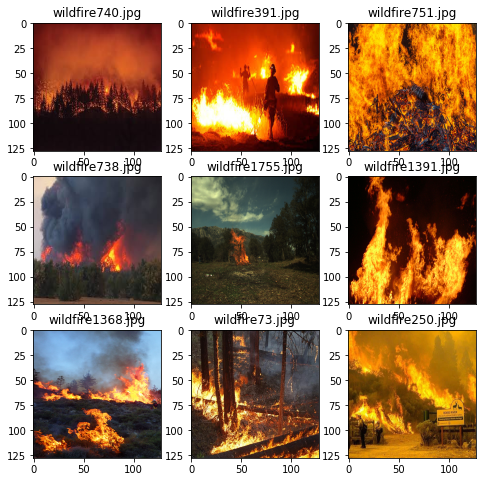

In [5]:
# Show 9 random images
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img_index = random.randrange(len(images_list))
    plt.imshow(cv2.cvtColor(images_list[img_index]['img'], cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title(images_list[img_index]['path'])
plt.show()

## PCA

I should note that our images have 3 channels. This means that we must decide if we are going to apply PCA independently on each channel **or** stack them together and perform one PCA.  
  
`channel_array` at the end of the cell below is an `ndarray` of shape $[channels, images, width * height]$. This is useful since we prefer the channels on the first axis.



In [3]:
# Create our 3 ndarrays for each channel
channels_numb = 3    # Images are RGB
channel_array = []
for which_channel in range(channels_numb):
    temp_channel = []    # Will hold the images of a specific channel on each iteration
    for which_img in images_list:
        temp_channel.append(which_img['img'][:, :, which_channel])
    channel_array.append(temp_channel)
    
channel_array = np.array(channel_array) # ndarray of shape #channels(3), #images(560), width, height

# We reshape so as to flatten width and height dimensions
channel_array = np.reshape(channel_array, (channels_numb, len(images_list), width * height))

### Independent PCAs on each channel

Independent PCA means that we will apply 3 PCAs (one on each channel) and then combine the results.  

In [6]:
pca_projections = []
# Iterate on the 3 channels
for which_channel in tqdm(range(channels_numb), desc='Performing PCA'):
    # PCA
    temp_pca = PCA(n_components=300)    # Initialize PCA
    temp_pca.fit(channel_array[which_channel])    # Fit on our channel
    X_transformed = temp_pca.transform(channel_array[which_channel])    # Transform our channel
    X_orig = temp_pca.inverse_transform(X_transformed)    # Inverse transform to return to our original feature space
    
    # Normalize to [0, 1] so as our values represent color values
    min_max_scaler = MinMaxScaler()    
    X_orig = min_max_scaler.fit_transform(X_orig)
    
    X_orig_reshape = np.reshape(X_orig, (len(images_list), width, height))    # Reshape so as to match the starting width and heights
    
    pca_projections.append(X_orig_reshape)

pca_projections = np.array(pca_projections)

# Moveaxis: [#channels, #images, width, height] -> [#images, width, height, #channels]
# This shape is printable by matplotlib
pca_projections = np.moveaxis(pca_projections, [0, 1], [3, 0])    

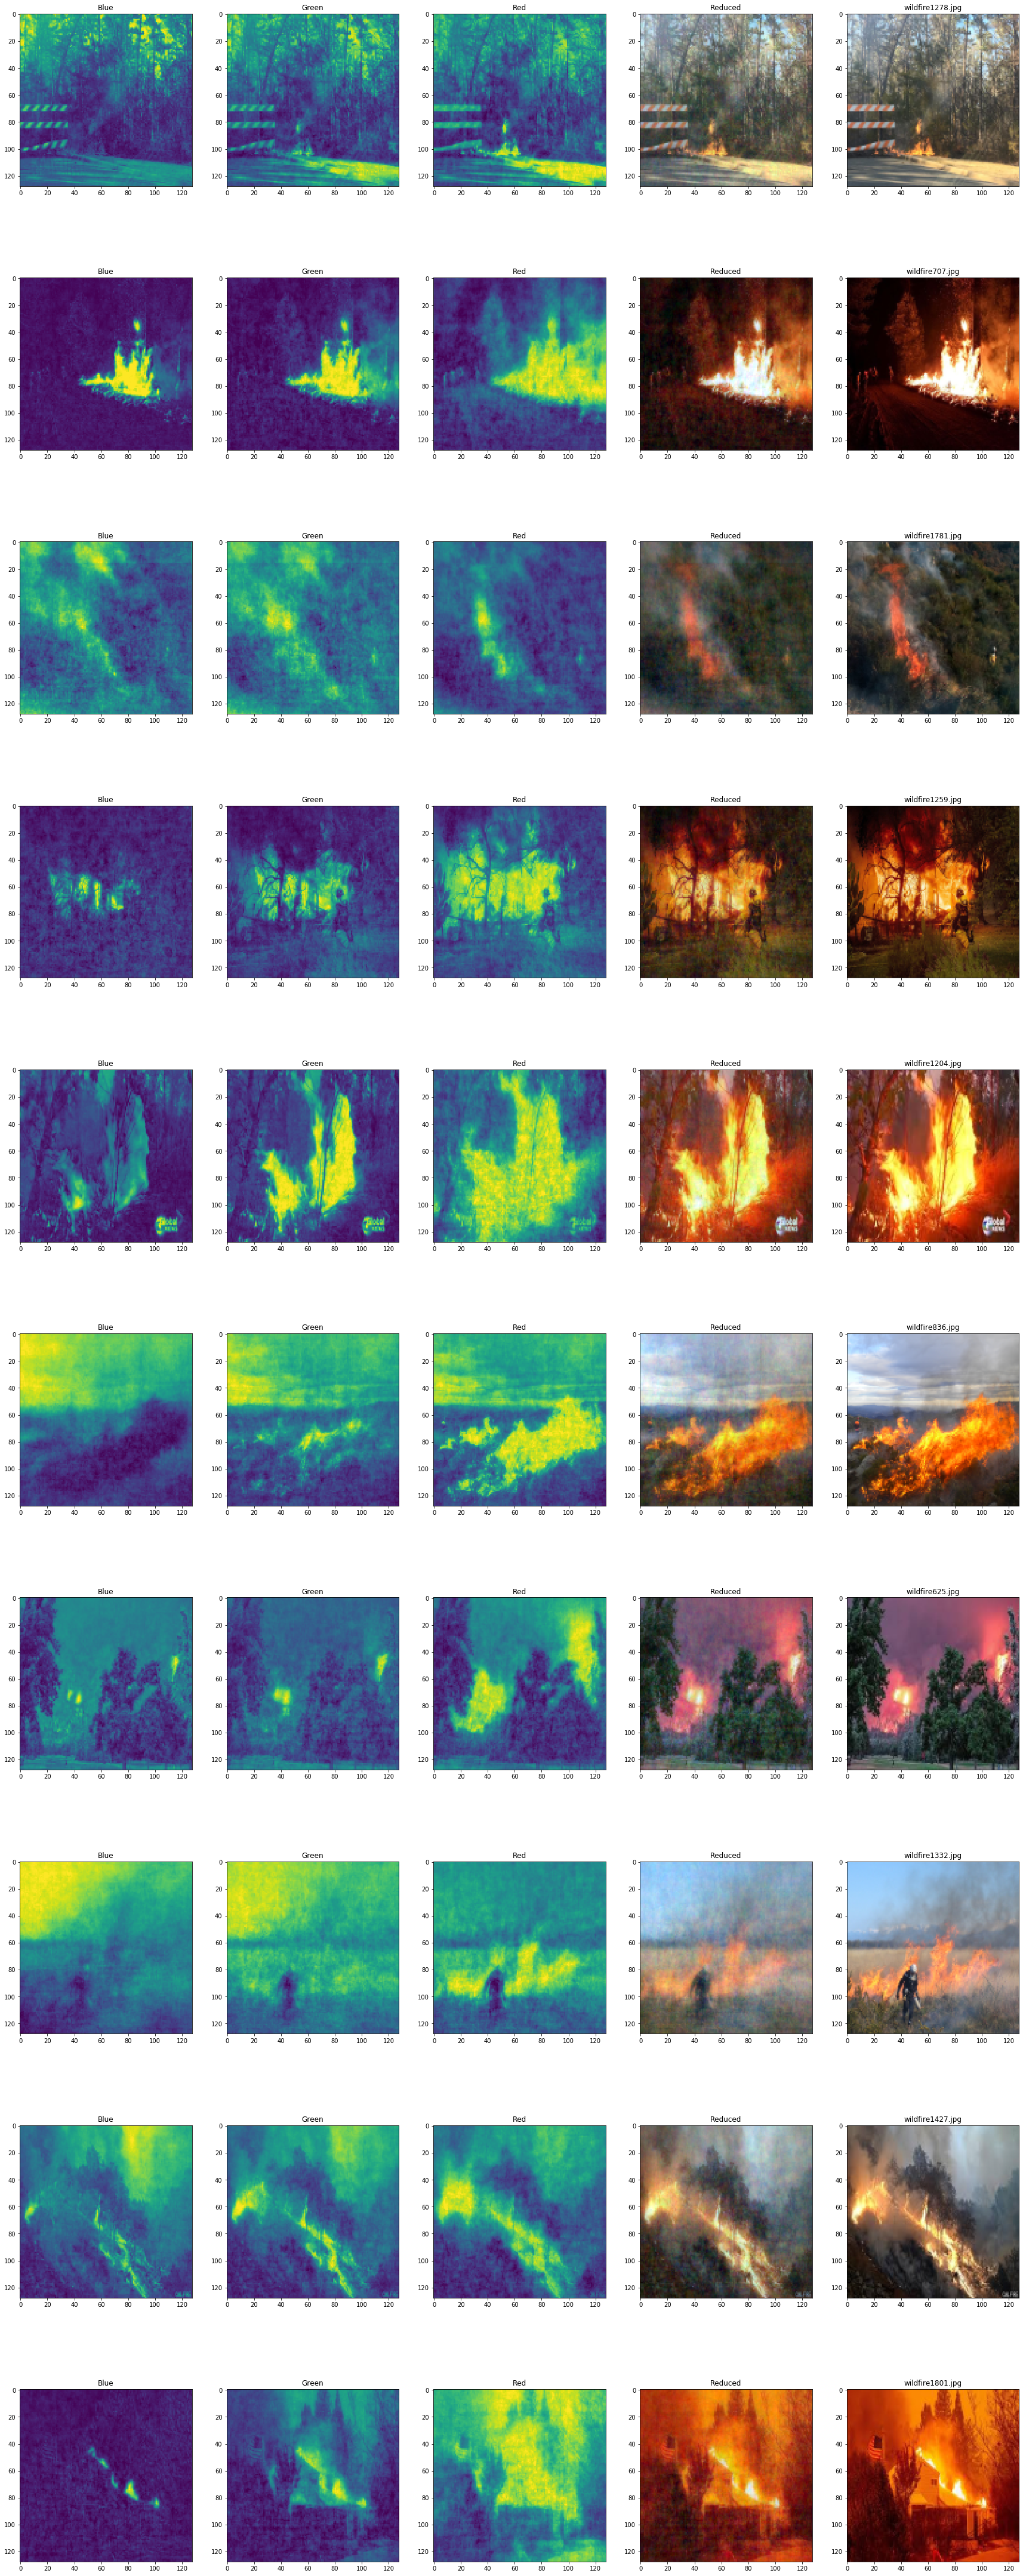

In [12]:
# Show random images
fig=plt.figure(figsize=(30, 80))
columns = 5
rows = 10
for i in range(1, columns*rows +1, 5):
    img_index = random.randrange(len(pca_projections))
    
    fig.add_subplot(rows, columns, i)
    plt.title('Blue')
    plt.imshow(pca_projections[img_index, :, :, 0])
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title('Green')
    plt.imshow(pca_projections[img_index, :, :, 1])
    
    fig.add_subplot(rows, columns, i + 2)
    plt.title('Red')
    plt.imshow(pca_projections[img_index, :, :, 2])
    
    fig.add_subplot(rows, columns, i + 3)
    plt.imshow(cv2.cvtColor(pca_projections[img_index].astype('float32'), cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title('Reduced')
    
    fig.add_subplot(rows, columns, i + 4)
    plt.imshow(cv2.cvtColor(images_list[img_index]['img'], cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title(images_list[img_index]['path'])
    
plt.show()

The above plots help us see the contribution of each color as well the final reconstructed reduced image.  
  
We observe that on the red channel the fires are greatly highlighted. However, the smoke on most of the images fails to be distinguished.

### PCA to all the channels

The second approach is to stack horizontally all the channels and apply one PCA on all of them together and then reshape back to the normal dimensions.

In [9]:
stacked_channels = np.reshape(np.moveaxis(channel_array, 0, 2), (560, -1))

stacked_pca = PCA(n_components=300)    # Initialize PCA
stacked_pca.fit(stacked_channels)    # Fit on our channel
X_transformed_stacked = stacked_pca.transform(stacked_channels)    # Transform our channel
X_orig_stacked = stacked_pca.inverse_transform(X_transformed_stacked)    # Inverse transform to return to our original feature space

# Normalize to [0, 1] so as our values represent color values
min_max_scaler = MinMaxScaler()
X_orig_stacked = min_max_scaler.fit_transform(X_orig_stacked)

# Reshape so as to match the starting width and heights of [#images, width, height, #channels]
X_orig_reshape_stacked = np.reshape(X_orig_stacked, (len(images_list), width, height, channels_numb))

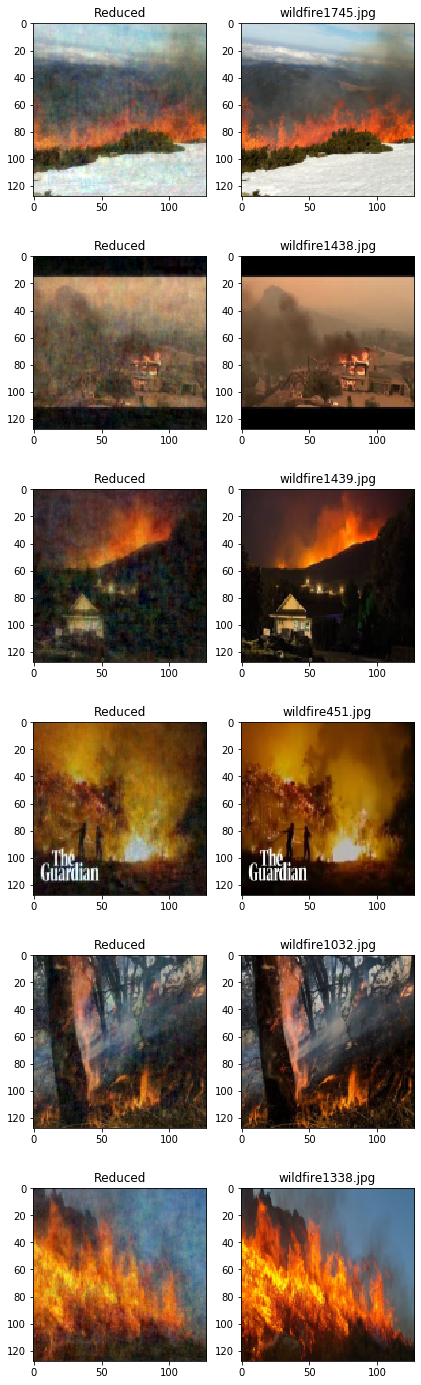

In [13]:
# Show random images
fig=plt.figure(figsize=(18, 25))
columns = 5
rows = 6
for i in range(1, columns*rows +1, 5):
    img_index = random.randrange(len(pca_projections))
    
    fig.add_subplot(rows, columns, i + 3)
    plt.imshow(cv2.cvtColor(X_orig_reshape_stacked[img_index].astype('float32'), cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title('Reduced')
    
    fig.add_subplot(rows, columns, i + 4)
    plt.imshow(cv2.cvtColor(images_list[img_index]['img'], cv2.COLOR_BGR2RGB)) # Convertion from BGR (OpenCV) to RGB
    plt.title(images_list[img_index]['path'])
    
plt.show()

## Conclusions

Our main goal was to create a new image dataset that a computer (Logistic Regression, RF, CNN)  will have an easier time on classifying if there is fire (or smoke) or not.
  
However, me as a human would prefer the original images. That is because we are amazingly trained on image recognition. The ML algorithms may actually benefit from this reduced image.  

So now we should:
* Augment our dataset to contain non fire images
* Test the reduced images and compare the resulted metrics on the original images dataset
* We could also apply PCA on local pixels eg 16x16